# CIS6800: Project 1b: Deep Learning Basics Part B

### Instructions:
* This is an individual assignment. Collaborating with others is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. You should only use PyTorch to complete this project.


In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt

%matplotlib inline
rng_seed = 1144

# Download MNIST
torchvision.datasets.MNIST('.', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

## 4. Adversarial Images (30%)
In this part you will see how you can use the gradients of the network to generate adversarial
images. Using these images that look almost identical the original you will be able to fool
different neural networks. You will also see that these images also affect different neural
networks and expose a security issue of CNNs that malicious users can take advantage of.
An example is shown in Figure 4. You are encouraged to read the relevant papers [1, 2]
before solving this part.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/fig4.png"/></div>

<center>Figure 4: An adversarial example demonstrated in [1].</center>

1. (10%) Use the trained network from question 3 to generate adversarial images with
constraints. The constraints that you have are:

  1. You are not allowed to erase parts of the image, i.e. $I_\text{pert} \ge I$ at each pixel location.
  2. The perturbed image has to take valid values, i.e. $-1 \le I_\text{pert} \le 1$.

  The algorithm works as follows:
  
  1. Let $I$ be a test image of your dataset that you want to perturb that is classified correctly by the network. Let $I_\epsilon$ be the perturbation that you should initialize
with zeros.
  2. Feed $I_\text{pert} = I + I_\epsilon$ in the network.
  3. Calculate the loss given the ground truth label ($y_\mathrm{gt}$). Let the loss be $L(x,y |\theta)$ where $\theta$ are the learned weights.
  4. Compute the gradients with respect to $I_\text{pert}$, i.e., $\nabla_{I_\text{pert}} L(I_\text{pert}, y_\mathrm{gt} | \theta)$. Using backpropagation, compute $\nabla_{I_\epsilon} L(I_\epsilon,y_\mathrm{gt} | \theta)$, i.e. the gradients with respect to the perturbation.
  5. Use the Fast Gradient Sign method to update the perturbation, i.e., $I_\epsilon = I_\epsilon + \epsilon\,\text{sign}(\nabla_{I_\epsilon} L(I_\epsilon, y_\mathrm{gt}))$, where $\epsilon$ is a small constant of your choice.
  6. Repeat A-D until the network classify the input image $I_\text{pert}$ as an arbitrary
wrong category with confidence (probability) at least $90\%$.

  Generate 2 examples of adversarial images. Describe the difference between the adversarial images and the original images.

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Create your network here (do not change this name)
class DigitClassification(torch.nn.Module):
    def __init__(self):
        super(DigitClassification, self).__init__()
        #convolution layers
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding="same"),  
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())        
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding="same"),  
                                   nn.BatchNorm2d(32),
                                   nn.ReLU()) 
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)      
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same"),  
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()) 
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        #linear layers
        self.linear1 = nn.Sequential(nn.Linear(64*3*3, 64), 
                                     nn.BatchNorm1d(64),
                                     nn.ReLU())
        self.linear2 = nn.Linear(64, 10) #discarded softmax as cross entropy loss does it implicitly
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.avgpool3(x)
        x = self.linear1(x.reshape(x.size(0), -1))
        x = self.linear2(x)
        return x

model_path = 'model.pth'
model = DigitClassification()
model.eval().load_state_dict(torch.load(model_path, map_location='cpu'))

#get N images from test dataset (N corresponds to the number of examples we want to show)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])
example_set = torchvision.datasets.MNIST(root='.', train=False, download=False, transform=transform)
example_loader = torch.utils.data.DataLoader(example_set, batch_size = 2, shuffle = True) #since we want 2 examples
images, labels = next(iter(example_loader)) 
#shape of images is [2, 1, 28, 28 ] meaning [instance number, no. of channels, height, width]
##shape of labels is [2] meaning label for each image instance

#predict on these N images. The index where the value is max is also the predicted number. That's why use argmax().
#E.g. if the value is 11.27 in index 4 of y_pred then the argmax retrieves index 4 which is also the predicted label "digit : 4" of the MNIST dataset.
y_pred = model(images).argmax(dim=1) 

In [3]:
print(y_pred)

tensor([3, 9])


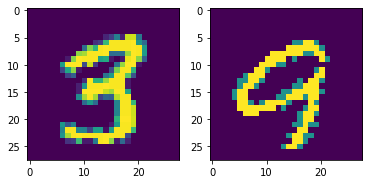

In [4]:
#visualize the original 2 examples
from PIL import Image
img_transform = torchvision.transforms.ToPILImage()
plt.figure()

plt.subplot(121)
img1 = img_transform(images[0])
plt.imshow(img1)

plt.subplot(122)
img2 = img_transform(images[1])
plt.imshow(img2)

tensor([3, 9])
tensor([3, 9])
tensor([3, 8])
tensor([3, 8])
tensor([8, 8])


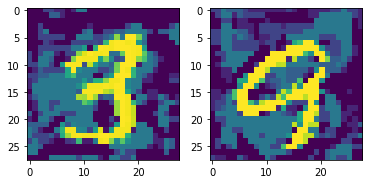

In [5]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def arbitrary_adversary(model, image, original_label):
  loss = nn.CrossEntropyLoss()
  e = 0.1 
  original_label_vec = torch.zeros(image.shape[0], 10) #convert label from size [N]  to size [N,10] to represent a prob distribution
  original_label_vec[[i for i in range(image.shape[0])], original_label] = 1
  #print(original_label_vec)
  image_e = torch.zeros_like(image, requires_grad=True)
  image_pert = torch.empty_like(image, requires_grad=True)
  conf = 0
  y_pred = original_label
  while not (conf > 0.9 and ((y_pred != original_label).all()==True)):
      image_pert = torch.clamp(image + image_e, -1, 1) #fulfiling constraint 2
      y_hat = model(image_pert)     #get the output of the network
      y_hat = torch.nn.functional.softmax(y_hat, dim=1)  #add softmax layer as we have not added it in the network
      y_pred = y_hat.argmax(dim=1)  #get the predicted label
      print(y_pred)
      conf = y_hat.max()         #get the confidence value
      #print(conf)
      model.zero_grad()
      l = loss(y_hat, original_label_vec)
      l_grad_pert = torch.autograd.grad(l, image_pert, retain_graph=True, grad_outputs=torch.ones_like(l))[0]
      l_grad_e = torch.autograd.grad(l, image_e, retain_graph=True, grad_outputs=torch.ones_like(l))[0]
      image_e = torch.clamp(image_e + e * torch.sign(l_grad_e), 0, None) #fulfilling constraint 1
      
  return image_pert

img_arb_pert = arbitrary_adversary(model, images, labels)

# Display images
plt.figure()

plt.subplot(121)
img1 = img_transform(img_arb_pert[0])
plt.imshow(img1)

plt.subplot(122)
img2 = img_transform(img_arb_pert[1])
plt.imshow(img2)

2. (10%) For a test image from the dataset, choose a target label yt that you want the network to classify your image as and compute a perturbed image. Note that this is different from what you are asked in part 1, because you want your network to believe that the image has a particular label, not just misclassify the image. You need to modify appropriately the loss function and then perform gradient descent as before. You should still use the constraints from part 1.

tensor([3, 9])
tensor([3, 9])
tensor([3, 8])
tensor([3, 9])
tensor([8, 9])
tensor([3, 8])
tensor([1, 5])
tensor([9, 9])
tensor([3, 8])
tensor([1, 0])
tensor([8, 0])
tensor([1, 0])
tensor([9, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([2, 0])
tensor([0, 0])


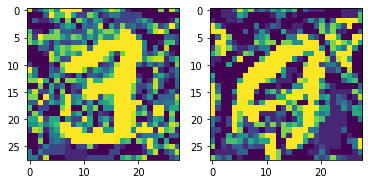

In [6]:
# don't change the signature of this function (image, image_pert -> [N, 1, H, W])
def targeted_adversary(model, image, target_label):
  loss = nn.CrossEntropyLoss()
  e = 0.1
  target_label_vec = torch.zeros(image.shape[0], 10) #convert label from size [1]  to size [1,10] to represent a prob distribution
  target_label_vec[:, target_label] = 1
  image_e = torch.zeros_like(image, requires_grad=True)
  image_pert = torch.empty_like(image, requires_grad=True)
  conf = 0
  y_pred = target_label
  while (conf < 0.9 or ((y_pred != target_label).all()==True)):
      image_pert = torch.clamp(image + image_e, -1, 1) #fulfilling constraint 2
      #print(image_pert)
      #if (image_e >= 0):
      y_hat = model(image_pert)     #get the output of the network
      y_hat = torch.nn.functional.softmax(y_hat, dim=1)  #add softmax layer as we have not added it in the network

      y_pred = y_hat.argmax(dim=1)  #get the predicted label
      print(y_pred)
      conf = y_hat.max()         #get the confidence value
      #print(conf)
      model.zero_grad()
      l = -loss(y_hat, target_label_vec)
      #print(l)
      l_grad_pert = torch.autograd.grad(l, image_pert, retain_graph=True, grad_outputs=torch.ones_like(l))[0]
      l_grad_e = torch.autograd.grad(l, image_e, retain_graph=True, grad_outputs=torch.ones_like(l))[0]
      image_e = torch.clamp(image_e + e * torch.sign(l_grad_e), 0, None) #fulfilling constraint 1
      
  return image_pert

img_target_pert = targeted_adversary(model, images, torch.tensor([0,2]))  #'[6,2]' is the target label

# Display images
plt.figure()

plt.subplot(121)
img1 = img_transform(img_target_pert[0])
plt.imshow(img1)

plt.subplot(122)
img2 = img_transform(img_target_pert[1])
plt.imshow(img2)

<!-- BEGIN QUESTION -->

3. (10%) Retrain the network from the previous problem. Use some of the adversarial images you generated in parts (1) and (2) and feed them in the retrained network. What do you observe?

_Type your answer here, replacing this text._

In [7]:
#from torch.autograd import Variable

In [8]:
'''
#Creating new train and test set for being robust to adverserial attack

#Creating new train set
og_train_set = torchvision.datasets.MNIST(root='.', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(og_train_set, batch_size = len(og_train_set), shuffle = False) #loading the whole thing in batch. Also do not shuffle
pert_train_loader = torch.utils.data.DataLoader(og_train_set, batch_size = 1000, shuffle = False) #get 1000 of the train data in batch for adv training. Also do not shuffle
og_images, og_labels = next(iter(train_loader))  #get original images and labels from the MNIST data
images, labels = next(iter(pert_train_loader))  #get 50 of the original images and labels from MNIST data
image_pert_train = arbitrary_adversary(model, images, labels)  #conduct perturbation on the images only 
new_train_images = Variable(torch.cat((og_images, image_pert_train)))   #create new set of images containing og images and perturbed images. Also wrap it in a Variable to allow gradients to be calculated later while training 
new_train_labels = Variable(torch.cat((og_labels, labels)))   #create new set of labels containing og labels and ground truth labels of perturbed imahes
new_train_dataset = torch.utils.data.TensorDataset(new_train_images, new_train_labels)  #combine images and labels to form a new dataset
new_train_loader = torch.utils.data.DataLoader(new_train_dataset, batch_size=32, shuffle = True)  #now use this loader in batch size 32 and also shuffle it this time

#Creating new test set
og_test_set = torchvision.datasets.MNIST(root='.', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(og_test_set, batch_size = len(og_test_set), shuffle = False)
pert_test_loader = torch.utils.data.DataLoader(og_test_set, batch_size = 50, shuffle = False)
og_images, og_labels = next(iter(test_loader)) 
images, labels = next(iter(pert_test_loader)) 
image_pert_test = arbitrary_adversary(model, images, labels)
new_test_images = Variable(torch.cat((og_images, image_pert_test)))
new_test_labels = Variable(torch.cat((og_labels, labels)))

new_test_dataset = torch.utils.data.TensorDataset(new_test_images, new_test_labels)
new_test_loader = torch.utils.data.DataLoader(new_test_dataset, batch_size=32, shuffle = True)
'''

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 2, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5,
        0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3,
        0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5,
        8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
        9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5,
        7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3,

In [9]:
'''
train_loss = []
test_loss = []
total_train_acc = []
total_test_acc = []

# Defining loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)   

# Train your network here
num_epochs = 10
for epoch in range(num_epochs):
  total_train_loss = 0
  total_test_loss = 0

  #training the model
  total = 0
  model.train()
  for idx, (image, label) in enumerate(new_train_loader):
    #zero out optimizer
    optimizer.zero_grad()
    #predict
    y_hat = model(image)
    #calculate the loss
    loss = loss_func(y_hat, label)
    #loss in epoch
    total_train_loss += loss.item()
    loss.backward()
    optimizer.step()

    y_hat = torch.nn.functional.softmax(y_hat, dim=1)

    for i, p in enumerate(y_hat):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

  train_acc = total/len(new_train_dataset)
  total_train_acc.append(train_acc)

  total_train_loss = total_train_loss/(idx + 1)
  train_loss.append(total_train_loss)

  #validating the model
  total = 0
  model.eval()
  for idx, (image, label) in enumerate(new_test_loader):
    y_hat = model(image)
    loss = loss_func(y_hat, label)

    total_test_loss += loss.item()

    y_hat = torch.nn.functional.softmax(y_hat, dim=1)

    for i, p in enumerate(y_hat):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

  test_acc = total/len(new_test_dataset)
  total_test_acc.append(test_acc)

  total_test_loss = total_test_loss/(idx + 1)
  test_loss.append(total_test_loss)

  print("Epoch %d/%d" % (epoch+1, num_epochs))
  print(test_acc)
'''

Epoch 1/10
0.9871641791044776
Epoch 2/10
0.9917412935323383
Epoch 3/10
0.9923383084577114
Epoch 4/10
0.9917412935323383
Epoch 5/10
0.9911442786069652
Epoch 6/10
0.9940298507462687
Epoch 7/10
0.9918407960199005
Epoch 8/10
0.992636815920398
Epoch 9/10
0.9927363184079602
Epoch 10/10
0.992139303482587


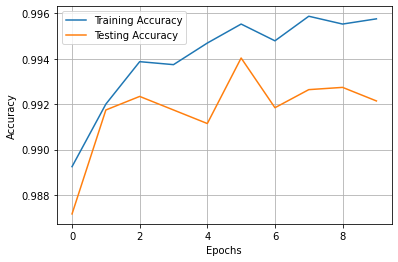

In [10]:
'''
plt.plot(total_train_acc, label='Training Accuracy')
plt.plot(total_test_acc, label='Testing Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
'''

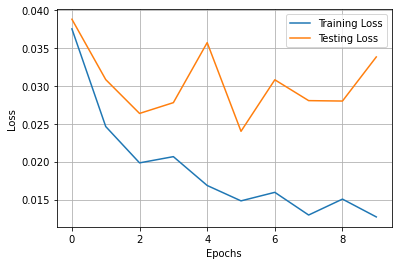

In [11]:
'''
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
'''

It is observed that on adding 1000 perturbed images to the train set, the test accuracy slightly decreased but the model became robust to adverserial attacks. Perturbing about 10% of the original train set would have increased the robustness of the model. But due to computation limitations, I chose to use 1000 examples for training.

<!-- END QUESTION -->

## References
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW1/images/refs.png"/, width=600
         ></div>

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (b), your submission should consist of two files: this notebook and the saved weights from question 3. There is no need to upload the new, retrained, weights.

**Please save before exporting!**